In [1]:
# -*- coding: utf-8 -*-
"""
Created on Thu Apr  1 13:47:43 2021

@author: bgourdon
"""

# Libraries needed for the tutorial

import pandas as pd
import requests
import io
import matplotlib.pyplot as plt 
import numpy as np



In [4]:
# Downloading the csv file from your GitHub account

url = "https://raw.githubusercontent.com/PlayingNumbers/ds_salary_proj/master/eda_data.csv" # Make sure the url is the raw version of the file on GitHub
download = requests.get(url).content

# Reading the downloaded content and turning it into a pandas dataframe

df = pd.read_csv(io.StringIO(download.decode('utf-8')))



# choose relevant columns 
df.columns

df_model = df[['avg_salary','Rating','Size','Type of ownership','Industry','Sector','Revenue','num_comp','hourly','employer_provided',
             'job_state','same_state','age','python_yn','spark','aws','excel','job_simp','seniority','desc_len']]
df.head()
# get dummy data 
df_dum = pd.get_dummies(df_model)

In [6]:

# train test split 
from sklearn.model_selection import train_test_split

X = df_dum.drop('avg_salary', axis =1)
y = df_dum.avg_salary.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# test_size means 20 percent test in the data set

# multiple linear regression 
import statsmodels.api as sm

X_sm = X = sm.add_constant(X)
model = sm.OLS(y,X_sm)
model.fit().summary()

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import cross_val_score

lm = LinearRegression()
lm.fit(X_train, y_train)

np.mean(cross_val_score(lm,X_train,y_train, scoring = 'neg_mean_absolute_error', cv= 3))

-20.76685512891771

,alpha,error
12,0.13,-19.257798


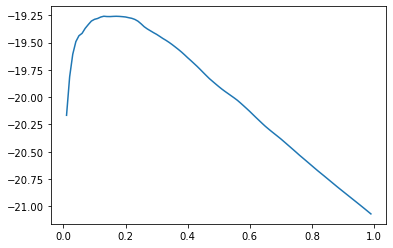

In [10]:
# lasso regression 
lm_l = Lasso(alpha=.13)
lm_l.fit(X_train,y_train)
np.mean(cross_val_score(lm_l,X_train,y_train, scoring = 'neg_mean_absolute_error', cv= 3))

alpha = []
error = []

for i in range(1,100):
    alpha.append(i/100)
    lml = Lasso(alpha=(i/100))
    error.append(np.mean(cross_val_score(lml,X_train,y_train, scoring = 'neg_mean_absolute_error', cv= 3)))
    
plt.plot(alpha,error)

err = tuple(zip(alpha,error))
df_err = pd.DataFrame(err, columns = ['alpha','error'])
df_err[df_err.error == max(df_err.error)]

In [12]:
# random forest 
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()

np.mean(cross_val_score(rf,X_train,y_train,scoring = 'neg_mean_absolute_error', cv= 3))

-15.134378129860364

In [13]:
# tune models GridsearchCV 
from sklearn.model_selection import GridSearchCV
parameters = {'n_estimators':range(10,300,10), 'criterion':('mse','mae'), 'max_features':('auto','sqrt','log2')}

gs = GridSearchCV(rf,parameters,scoring='neg_mean_absolute_error',cv=3)
gs.fit(X_train,y_train)

gs.best_score_
gs.best_estimator_

RandomForestRegressor(n_estimators=230)

In [14]:
# test ensembles 
tpred_lm = lm.predict(X_test)
tpred_lml = lm_l.predict(X_test)
tpred_rf = gs.best_estimator_.predict(X_test)

from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test,tpred_lm)
mean_absolute_error(y_test,tpred_lml)
mean_absolute_error(y_test,tpred_rf)

10.944849722789613

In [ ]:

import pickle
pickl = {'model': gs.best_estimator_}
pickle.dump( pickl, open( 'model_file' + ".p", "wb" ) )

file_name = "model_file.p"
with open(file_name, 'rb') as pickled:
    data = pickle.load(pickled)
    model = data['model']

model.predict(np.array(list(X_test.iloc[1,:])).reshape(1,-1))[0]

list(X_test.iloc[1,:])